In [56]:
import os
from pathlib import Path
from itertools import islice
import gzip
import pickle

import numpy as np
import matplotlib.pyplot as plt

from bokeh.io import push_notebook, show, output_notebook, output_file
from bokeh.plotting import figure, ColumnDataSource, save
from bokeh.transform import linear_cmap
from bokeh.palettes import Plasma11, Viridis11
from bokeh.util.hex import hexbin
from bokeh.layouts import gridplot
output_notebook()

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

from foresight.ei import ei

Loading BokehJS ...

In [2]:
dir_path = Path().absolute()
dataset_path = dir_path.parent / "data/mnist.pkl.gz"
if not dataset_path.exists():
    print('Downloading dataset with curl ...')
    if not dataset_path.parent.exists():
        os.mkdir(dataset_path.parent)
    url = 'http://ericjmichaud.com/downloads/mnist.pkl.gz'
    os.system('curl -L {} -o {}'.format(url, dataset_path))
print('Download failed') if not dataset_path.exists() else print('Dataset acquired')
f = gzip.open(dataset_path, 'rb')
mnist = pickle.load(f)
f.close()
print('Loaded data to variable `mnist`')

Dataset acquired
Loaded data to variable `mnist`


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# dtype = torch.cuda.float if torch.cuda.is_available() else torch.float
dtype = torch.float32
torch.set_default_dtype(dtype)

In [4]:
device

device(type='cuda')

In [5]:
class MNISTDataset(Dataset):
    """MNIST Digits Dataset."""
    def __init__(self, data, transform=None):
        self.mnist = data
        self.transform = transform
        
    def __len__(self):
        return len(self.mnist)

    def __getitem__(self, idx):
        sample = self.mnist[idx]
        if self.transform:
            sample = self.transform(sample)
        return sample

class ToTensor(object):
    """Convert samples (np.ndarray, np.ndarray) to (torch.tensor, torch.tensor)"""
    def __call__(self, sample):
        image, one_hot_label = sample
        image = torch.from_numpy(image).to(dtype)
        label = torch.tensor(np.argmax(one_hot_label)).to(torch.long)
        return (image, label)


In [6]:
class SoftmaxRegression(nn.Module):
    """Single-layer softmax network."""
    def __init__(self, n_in, n_out):
        super(SoftmaxRegression, self).__init__()
        self.linear = nn.Linear(n_in, n_out, bias=False)
    
    def forward(self, x):
        return F.log_softmax(self.linear(x), dim=1)
    
    
class FullyConnected(nn.Module):
    """Single-hidden-layer dense neural network."""
    def __init__(self, *layers):
        super(FullyConnected, self).__init__()
        self.layers = nn.ModuleList()
        for i in range(len(layers) - 1):
            self.layers.append(nn.Linear(layers[i], layers[i+1], bias=False))
        
    def forward(self, x):
        for i in range(len(self.layers) - 1):
            x = torch.tanh(self.layers[i](x))
        return F.log_softmax(self.layers[i+1](x), dim=1)

## No Hidden Layer Softmax Network

In [7]:
training = MNISTDataset(mnist[:60000], transform=ToTensor())
test = MNISTDataset(mnist[60000:], transform=ToTensor())
training_loader = torch.utils.data.DataLoader(training, batch_size=20, shuffle=True)
test_loader = torch.utils.data.DataLoader(test, batch_size=20, shuffle=True)

In [49]:
model = SoftmaxRegression(28*28, 10).to(device)
# model = FullyConnected(28*28, 500, 500, 10).to(device)
loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters())

In [50]:
# --- MATPLOTLIB DATA ---
num_batches_data = []
eis_data = []
losses_data = [] #[(train, test), (train, test), ...]
accuracies_data = []


# --- DEFINE BOKEH OUTPUT ---

# source = ColumnDataSource(data={
#     'num_batches': [],
#     'training_loss': [],
#     'test_loss': [],
#     'EI': []
# })

# loss_plot = figure(plot_width=800, plot_height=150, 
#                        x_axis_label='batches', title='Loss')
# EI_plot = figure(plot_width=800, plot_height=150,
#                 x_axis_label='batches', y_axis_label='bits', title='Effective Information')
# # weight_image = figure(plot_width=5*150, plot_height=2*150, title='Output Weights')
# # weight_image.xgrid.visible = False
# # weight_image.ygrid.visible = False

# loss_plot.line('num_batches', 'test_loss', source=source, line_width=2, color='red')
# loss_plot.line('num_batches', 'training_loss', source=source, line_width=2, color='green')
# EI_plot.line('num_batches', 'EI', source=source, line_width=2)
# # weight_image.image([np.zeros((784, 10)).reshape(112, -1)], 0, 0, 1, 1, palette=Plasma11)

# grid = gridplot([[loss_plot], [EI_plot]])
# display = show(grid, notebook_handle=True)

def update_metrics():
    with torch.no_grad():
        input = next(iter(test_loader))[0].to(device)
        EI = ei(model, input=input, device=device)
    
    outof = 0
    loss = 0
    with torch.no_grad():
        for x, labels in islice(test_loader, 0, 500): # 500 batches of 20 samples
            output = model(x.to(device))
            loss += loss_fn(output, labels.to(device)).item()
            _, pred = torch.max(output, 1)
            outof += len(labels)
    test_loss = loss / outof
    
    outof = 0
    loss = 0
    with torch.no_grad():
        for x, labels in islice(training_loader, 0, 500): # 500 batches of 20 samples
            output = model(x.to(device))
            loss += loss_fn(output, labels.to(device)).item()
            _, pred = torch.max(output, 1)
            outof += len(labels)
    training_loss = loss / outof
    
    outof = 0
    accuracy = 0
    with torch.no_grad():
        for x, labels in test_loader:
            output = model(x.to(device))
            _, pred = torch.max(output, 1)
            accuracy += (pred == labels.to(device)).sum().item()
            outof += len(labels)
    accuracy = accuracy / outof
    
#     source.stream({
#         'num_batches': [num_batches],
#         'training_loss': [training_loss],
#         'test_loss': [test_loss],
#         'EI': [EI]
#     })
#     weight = model.linear.weight.cpu().detach().numpy()
#     for i in range(len(weight)):
#         x = i % 5
#         y = i // 5
#         weight_image.image([weight[i].reshape(28, 28)], x*29, -y*29, 28, 28, palette=Viridis11)
    # push_notebook(handle=display)
    
    num_batches_data.append(num_batches)
    eis_data.append(EI)
    losses_data.append((training_loss, test_loss))
    accuracies_data.append(accuracy)
    
    if num_batches % 1500 == 0:
        print("Epoch: {:3d} | EI: {:2.3f} | Accuracy: {:0.3f}".format(epoch, EI, accuracy))
    
# --- TRAIN ---

num_batches = 0
for epoch in range(80):
    for sample, target in training_loader:
        optimizer.zero_grad()
        loss = loss_fn(model(sample.to(device)), target.to(device))
        loss.backward()
        optimizer.step()
        num_batches += 1
        if num_batches % 100 == 0:
            update_metrics()

Epoch:   0 | EI: 1.916 | Accuracy: 0.907
Epoch:   0 | EI: 1.907 | Accuracy: 0.918
Epoch:   1 | EI: 1.900 | Accuracy: 0.921
Epoch:   1 | EI: 1.887 | Accuracy: 0.921
Epoch:   2 | EI: 1.884 | Accuracy: 0.923
Epoch:   2 | EI: 1.868 | Accuracy: 0.920
Epoch:   3 | EI: 1.863 | Accuracy: 0.922
Epoch:   3 | EI: 1.857 | Accuracy: 0.925
Epoch:   4 | EI: 1.848 | Accuracy: 0.926
Epoch:   4 | EI: 1.852 | Accuracy: 0.923
Epoch:   5 | EI: 1.844 | Accuracy: 0.924
Epoch:   5 | EI: 1.845 | Accuracy: 0.924
Epoch:   6 | EI: 1.840 | Accuracy: 0.928
Epoch:   6 | EI: 1.838 | Accuracy: 0.924
Epoch:   7 | EI: 1.838 | Accuracy: 0.925
Epoch:   7 | EI: 1.837 | Accuracy: 0.926
Epoch:   8 | EI: 1.837 | Accuracy: 0.925
Epoch:   8 | EI: 1.838 | Accuracy: 0.926
Epoch:   9 | EI: 1.841 | Accuracy: 0.925
Epoch:   9 | EI: 1.834 | Accuracy: 0.924
Epoch:  10 | EI: 1.835 | Accuracy: 0.926
Epoch:  10 | EI: 1.836 | Accuracy: 0.925
Epoch:  11 | EI: 1.833 | Accuracy: 0.925
Epoch:  11 | EI: 1.837 | Accuracy: 0.926
Epoch:  12 | EI:

In [54]:
# import pickle
# with open("plots/plot0/graph_data.pkl", "wb") as f:
#     pickle.dump((num_batches_data, accuracies_data, train_losses, test_losses, eis_data), f)

In [64]:
import matplotlib.style as style 
style.available

['seaborn-white',
 'tableau-colorblind10',
 'ggplot',
 'seaborn-muted',
 'seaborn-deep',
 'grayscale',
 'fivethirtyeight',
 'seaborn-pastel',
 'seaborn-darkgrid',
 'seaborn-colorblind',
 'seaborn-whitegrid',
 'dark_background',
 'seaborn-dark',
 'fast',
 '_classic_test',
 'seaborn-ticks',
 'classic',
 'seaborn-dark-palette',
 'seaborn-paper',
 'seaborn-bright',
 'Solarize_Light2',
 'seaborn',
 'bmh',
 'seaborn-talk',
 'seaborn-notebook',
 'seaborn-poster']

In [57]:
import pickle
with open("plots/plot0/graph_data.pkl", "rb") as f:
    num_batches_data, accuracies_data, train_losses, test_losses, eis_data = pickle.load(f)

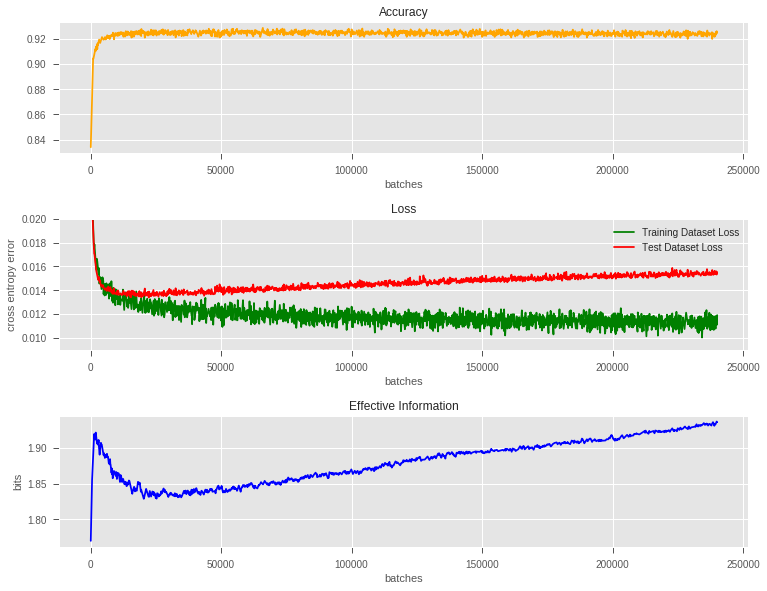

In [90]:
style.use('seaborn-notebook')
plt.figure(figsize=(11, 9))
# plt.suptitle("Accuracy, Loss, and Effective Information")

plt.subplot(3, 1, 1)
plt.title("Accuracy")
plt.plot(num_batches_data, accuracies_data, color='orange')
plt.xlabel("batches")

plt.subplot(3, 1, 2)
plt.title("Loss")
plt.plot(num_batches_data, train_losses, label="Training Dataset Loss", color='green')
plt.plot(num_batches_data, test_losses, label="Test Dataset Loss", color='red')
plt.xlabel("batches")
plt.ylabel("cross entropy error")
plt.ylim(0.009, 0.02)
plt.legend()

plt.subplot(3, 1, 3)
plt.title("Effective Information")
plt.plot(num_batches_data, eis_data, color='blue')
plt.xlabel("batches")
plt.ylabel("bits")

plt.subplots_adjust(hspace=0.5)

plt.savefig("single-layer-softmax-graph.png", dpi=200)

In [10]:
# output_file('plots/plot0/save.html')
# save(grid)

'/home/eric/Code/ai-experiments/effective-information/plots/plot0/save.html'